<a href="https://colab.research.google.com/github/jeanluckei/deep-learning/blob/main/knn-apple-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget https://github.com/jeanluckei/deep-learning/raw/main/fruits-360.zip
!unzip fruits-360-test.zip

In [2]:
import numpy as np
from keras.preprocessing import image
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
print("Files imported successfully")
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)

Files imported successfully


In [5]:
def load_image_files(container_path, dimension=(64, 64)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    count = 0
    train_img = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            img = imread(file)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img_pred = cv.resize(img, (50, 50), interpolation=cv.INTER_AREA)
            img_pred = image.img_to_array(img_pred)
            img_pred = img_pred / 255
            train_img.append(img_pred)

    X = np.array(train_img)

    return X

X = []
X = load_image_files("fruits-360-test/Training")

y0 = np.zeros(420)
#420 is the number of Braeburn in X
y1 = np.ones(420)
#420 is the number of Golden in X
y = []
y = np.concatenate((y0,y1), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5)
print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("X_val: "+str(X_val.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))
print("y_val: "+str(y_val.shape))

from builtins import range
from builtins import object

num_training = X_train.shape[0]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = X_test.shape[0]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

num_val = X_val.shape[0]
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("X_val: "+str(X_val.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))
print("y_val: "+str(y_val.shape))

X_train: (672, 50, 50, 1)
X_test: (84, 50, 50, 1)
X_val: (84, 50, 50, 1)
y_train: (672,)
y_test: (84,)
y_val: (84,)
X_train: (672, 2500)
X_test: (84, 2500)
X_val: (84, 2500)
y_train: (672,)
y_test: (84,)
y_val: (84,)


In [6]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def predict_label(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances_no_loops(X)

        return self.predict_labels(dists, k=k)

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        dists = np.sqrt((X ** 2).sum(axis=1, keepdims=1) + (self.X_train ** 2).sum(axis=1) - 2 * X.dot(self.X_train.T))

        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            closest_y = closest_y.astype(int)
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

In [7]:
print("Val Accuracy for k=1")
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_no_loops(X_val)
y_val_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(y_val_pred == y_val)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Val Accuracy for k=1
Got 84 / 84 correct => accuracy: 1.000000


Using SKLEARN


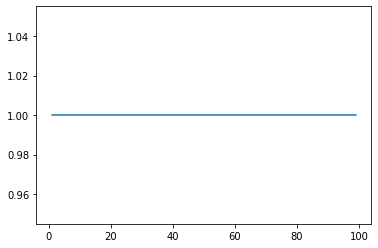

max acc at k=1 acc of 1.0


In [8]:
print("Using SKLEARN")
lix = []
liy = []
index=0
acc=0
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    liy.append(neigh.score(X_val, y_val))
    if liy[k-1]>acc:
        acc=liy[k-1]
        index=k-1
    lix.append(k)

plt.plot(lix, liy)
plt.show()
print("max acc at k="+str(index+1)+" acc of "+str(acc))

In [9]:
neigh = KNeighborsClassifier(n_neighbors=43)
neigh.fit(X_train, y_train)
print("Test Accuracy: "+str(neigh.score(X_test, y_test)))

print("Using our own k-NN")
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_no_loops(X_test)
y_test_pred = classifier.predict_labels(dists, k=43)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('With k = 43 Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Test Accuracy: 1.0
Using our own k-NN
With k = 43 Got 84 / 84 correct => accuracy: 1.000000


In [19]:
print("Predicting custom image")
img = cv.imread("download.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_pred = cv.resize(img, (50, 50), interpolation=cv.INTER_AREA)
img_pred = image.img_to_array(img_pred)
img_pred = img_pred/255
img_pred = np.reshape(img_pred, (1, img_pred.shape[0]*img_pred.shape[1]))

classifier2 = KNearestNeighbor()
classifier2.train(X_train, y_train)
# Test your implementation:
dists2 = classifier2.compute_distances_no_loops(img_pred)
labels = ["Braeburn", "Golden"]
y_test_pred = classifier2.predict_labels(dists2, k=43)
print(labels[int(y_test_pred)])

Predicting custom image
Braeburn
